In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np
from scipy.stats import kstest
import warnings
warnings.filterwarnings("ignore")
data = pd.read_excel('dataset_после_очистки.xlsx')

In [2]:
data.head(100)

,procedural_fairness,group,econ_attitude,ideology,gender,age,educ,income_level,location,result_fairness,result_interest,parliament_decision,procedure_type,public_parliament_agreement
0,6,1,1,4,2,26,3,3,3,6,7,1,0,0
1,5,1,4,4,2,29,5,4,4,3,3,1,0,0
2,7,1,4,5,2,36,2,3,2,7,7,1,0,0
3,3,1,6,5,1,27,5,4,2,3,3,1,0,0
4,6,1,2,1,1,52,5,3,4,4,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6,0,5,5,1,42,2,3,4,6,3,0,0,0
96,2,0,3,4,1,43,4,4,1,2,2,0,0,0
97,5,0,4,4,1,51,5,3,5,2,3,0,0,0
98,4,0,1,4,2,37,5,4,2,4,4,0,0,0


In [3]:
data['gender'] = data['gender'].apply(lambda x: 1 if x == 2 else 0)

### зависимые переменные:  

* procedural_fairness: 
процедурная справедливость - шкала от 1 до 7 (от совершенно несправедливо до совершенно справедливо)  

*  result_fairness
справедливость результата - шкала от 1 до 7 (от совершенно несправедливо до совершенно справедливо) 

*  result_interest
насколько принятое решение соответствует вашим интересам? - от 1 до 7 (от совершенно не соответствует до скорее соответствует)

### контрольные переменные:  
*   group: 0-9  
0 и 1 - контрольные группы (стандартная парламентская процедура без включения демократических инноваций), 0 - закон не принят, 1 - закон принят  
2, 3, 4, 5: deliberation treatment ('День обсуждения' + присутствие экспертов + метод жребия из всех + решение парламента нельзя пересмотреть) - ранжирование по - граждане проголосовали за/против введения закона + депутаты за/против закона (например, 2 экспериментальная група +/+, 3гр +/-, 4гр -/+, 5 гр -/-)  
6, 7, 8, 9: agonistic treatment ('День политических дебатов' + отсутствие экспертов + метод жребия из конфликтных групп + решения парламента можно пересмотреть) - ранжирование по - граждане проголосовали за/против введения закона + депутаты за/против закона (например, 6 экспериментальная група +/+, 7гр +/-, 8гр -/+, 9-/-)

*  procedure_type (0-2):
0 - контрольная группа 1 + контрольная группа 2 
1 - делиберативный treatment
2 - агонистический treatment

*   parliament_decision (0 и 1):
0 - закон не принят парламентом 
1 - закон принят парламентом 

*  public_parliament_agreement (когда согласуется мнение и депутатов и граждан):
0 - не согласовано 
1 - согласовано 

*   ideology (от 1 до 7):
Этот вопрос измеряет приоритет респондента между индивидуальными интересами и общественным благом по шкале семантического дифференциала.
Чем ближе значение к 1, тем сильнее респондент склоняется к индивидуализму. Чем ближе к 7, тем сильнее выражена ориентация на коллективизм и общественные интересы. Значение 4 указывает на нейтральную или неопределённую позицию.

*  econ_attitude (от 1 до 7):
Респонденту предлагалось выбрать, какая экономическая система ему ближе — плановая (с госрегулированием) или рыночная (с частной собственностью). Чем ближе значение к 1, тем выше ориентация респондента на этатизм и государственное вмешательство.
Чем ближе к 7, тем сильнее выражены либеральные, рыночные экономические предпочтения.

*  gender (1 и 2):  
1 - мужчина
2 - женщина

*  income_level (от 1 до 5):
Чем выше значение, тем выше уровень экономического комфорта и благосостояния по субъективной самооценке респондента.

* age - возраст

*  educ - образование (от 1 до 5):
Чем выше балл, тем выше образовательный статус респондента с точки зрения формального уровня подготовки.

*  location (от 1 до 6):
Чем выше значение, тем менее урбанизирована среда проживания, что может использоваться для анализа различий в восприятии и поведении между жителями разных типов населённых пунктов.

## Описательные статистики и проверка на нормальность распределения:

In [4]:
#распределение по полу: 1-мужчина, 2-женщина
counts = data['gender'].value_counts()
percentages = data['gender'].value_counts(normalize=True) * 100
print(counts)
print(percentages)

gender
1    288
0    246
Name: count, dtype: int64
gender
1    53.932584
0    46.067416
Name: proportion, dtype: float64


In [5]:
#расределение по возрасту
age = data['age']
age_min = age.min()
age_max = age.max()
age_mean = age.mean()
age_std = age.std()

print(f"Возраст от {age_min} до {age_max} лет (M = {age_mean:.1f} лет, SD = {age_std:.1f})")

Возраст от 18 до 64 лет (M = 36.9 лет, SD = 10.1)


In [6]:
#посмотрим количество человек в каждой группе:
counts = data['group'].value_counts()

print(f"Количество человек в каждой группе: {counts}")

#в случае одной контрольной и двух экспериментальных
cr = [0, 1] 
counts_cr = data[data['group'].isin(cr)]['group'].value_counts()

print(f"В случае одной контрольной и двух экспериментальных: {counts_cr}")

delib_group = [2, 3, 4, 5] 
counts_delib = data[data['group'].isin(delib_group)]['group'].value_counts()

print(f"В группах с делиберативной инновацией: {counts_delib}")

agonist_group = [6, 7, 8, 9]
counts_agonist = data[data['group'].isin(agonist_group)]['group'].value_counts()
print(f"В группах с агонистической инновацией: {counts_agonist}")

Количество человек в каждой группе: group
1    62
0    59
5    56
8    54
7    53
3    52
6    52
9    52
2    47
4    47
Name: count, dtype: int64
В случае одной контрольной и двух экспериментальных: group
1    62
0    59
Name: count, dtype: int64
В группах с делиберативной инновацией: group
5    56
3    52
2    47
4    47
Name: count, dtype: int64
В группах с агонистической инновацией: group
8    54
7    53
6    52
9    52
Name: count, dtype: int64


In [7]:
df = data['procedural_fairness'].dropna()

df_np = df.to_numpy().flatten()

stat, p = kstest(df_np, 'norm')

print(f'Kolmogorov-Smirnov test "procedural_fairness": stat={stat:.3f}, p={p:.3f}')
df = data['result_fairness'].dropna()

df_np = df.to_numpy().flatten()

stat, p = kstest(df_np, 'norm')

print(f'Kolmogorov-Smirnov "result_fairness": stat={stat:.3f}, p={p:.3f}')

df = data['result_interest'].dropna()

df_np = df.to_numpy().flatten()

stat, p = kstest(df_np, 'norm')

print(f'Kolmogorov-Smirnov "result_interest": stat={stat:.3f}, p={p:.3f}')

Kolmogorov-Smirnov test "procedural_fairness": stat=0.962, p=0.000
Kolmogorov-Smirnov "result_fairness": stat=0.947, p=0.000
Kolmogorov-Smirnov "result_interest": stat=0.944, p=0.000


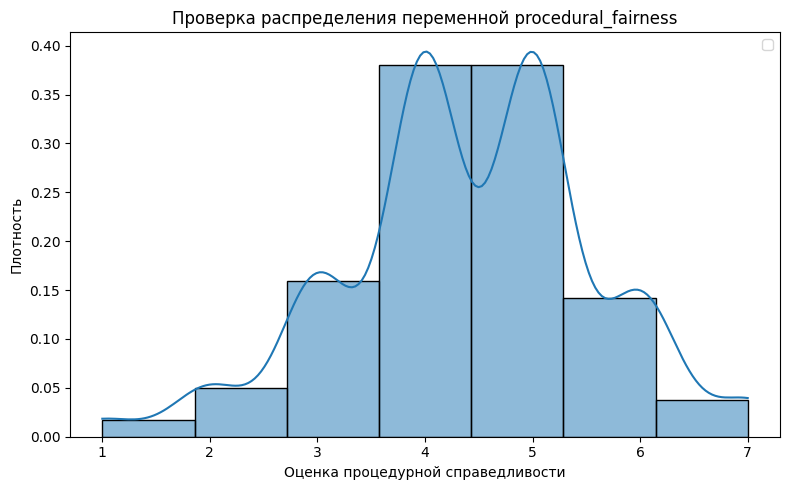

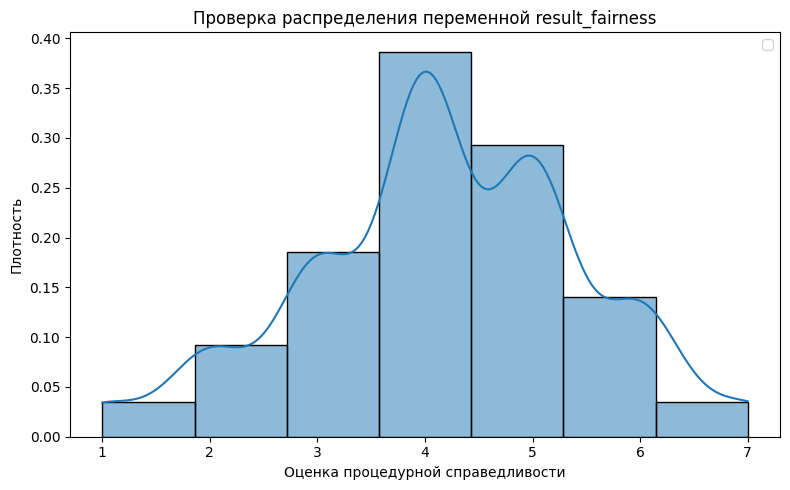

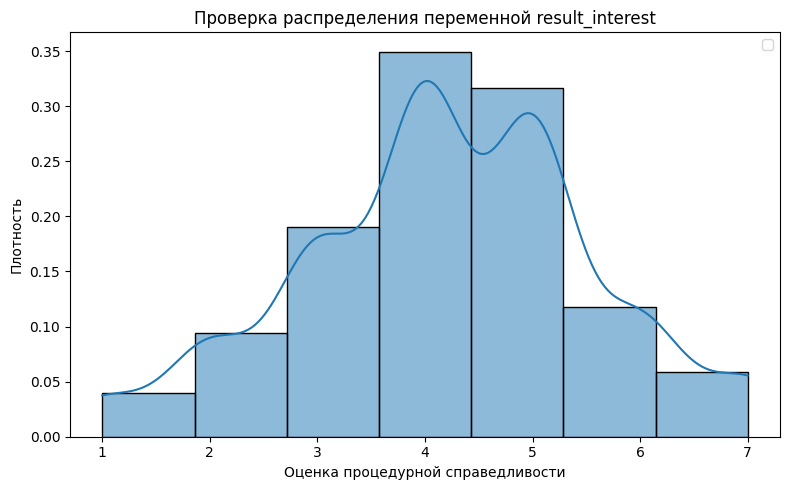

In [8]:
df = data['procedural_fairness'].dropna()

plt.figure(figsize=(8, 5))
sns.histplot(df, bins=7, kde=True, stat="density", edgecolor='black')
mean = df.mean()
std = df.std()

plt.title('Проверка распределения переменной procedural_fairness')
plt.xlabel('Оценка процедурной справедливости')
plt.ylabel('Плотность')
plt.savefig("hist_plot_proced_fairness.png", dpi=300) 

plt.legend()
plt.tight_layout()
plt.show()

df = data['result_fairness'].dropna()
plt.figure(figsize=(8, 5))
sns.histplot(df, bins=7, kde=True, stat="density", edgecolor='black')
mean = df.mean()
std = df.std()
x = np.linspace(df.min(), df.max(), 100)

plt.title('Проверка распределения переменной result_fairness')
plt.xlabel('Оценка процедурной справедливости')
plt.ylabel('Плотность')
plt.savefig("hist_plot_result_fairness.png", dpi=300) 
plt.legend()
plt.tight_layout()
plt.show()

df = data['result_interest'].dropna()
plt.figure(figsize=(8, 5))
sns.histplot(df, bins=7, kde=True, stat="density", edgecolor='black')
mean = df.mean()
std = df.std()

plt.title('Проверка распределения переменной result_interest')
plt.xlabel('Оценка процедурной справедливости')
plt.ylabel('Плотность')
plt.savefig("hist_plot_res_interest.png", dpi=300) 
plt.legend()
plt.tight_layout()
plt.show()

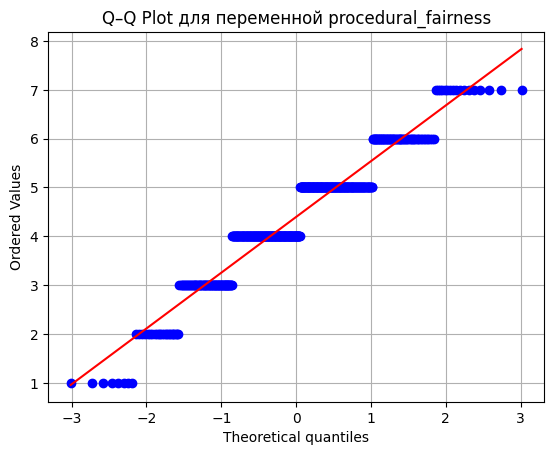

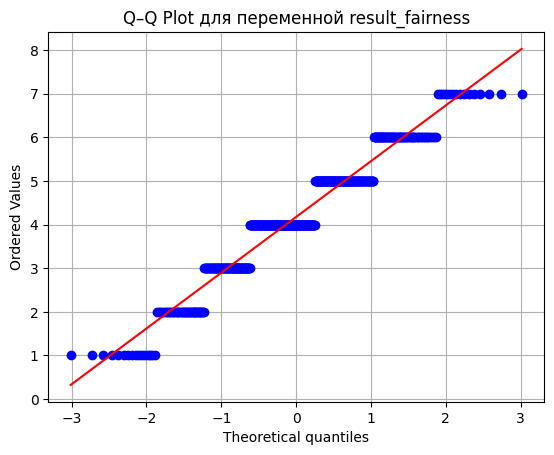

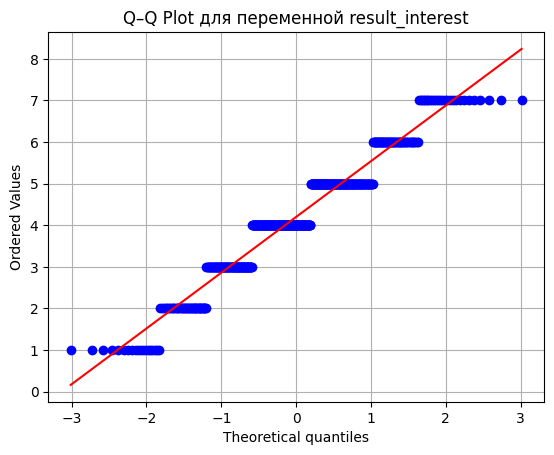

In [9]:
df = data['procedural_fairness'].dropna()
stats.probplot(df, dist="norm", plot=plt)
plt.title("Q–Q Plot для переменной procedural_fairness")
plt.grid(True)
plt.savefig("qq_procedural_fairness.png", dpi=300) 
plt.show()

df = data['result_fairness'].dropna()
stats.probplot(df, dist="norm", plot=plt)
plt.title("Q–Q Plot для переменной result_fairness")
plt.grid(True)
plt.savefig("qq_result_fairness.png", dpi=300) 
plt.show()

df = data['result_interest'].dropna()
stats.probplot(df, dist="norm", plot=plt)
plt.title("Q–Q Plot для переменной result_interest")
plt.grid(True)
plt.savefig("result_interest.png", dpi=300) 
plt.show()

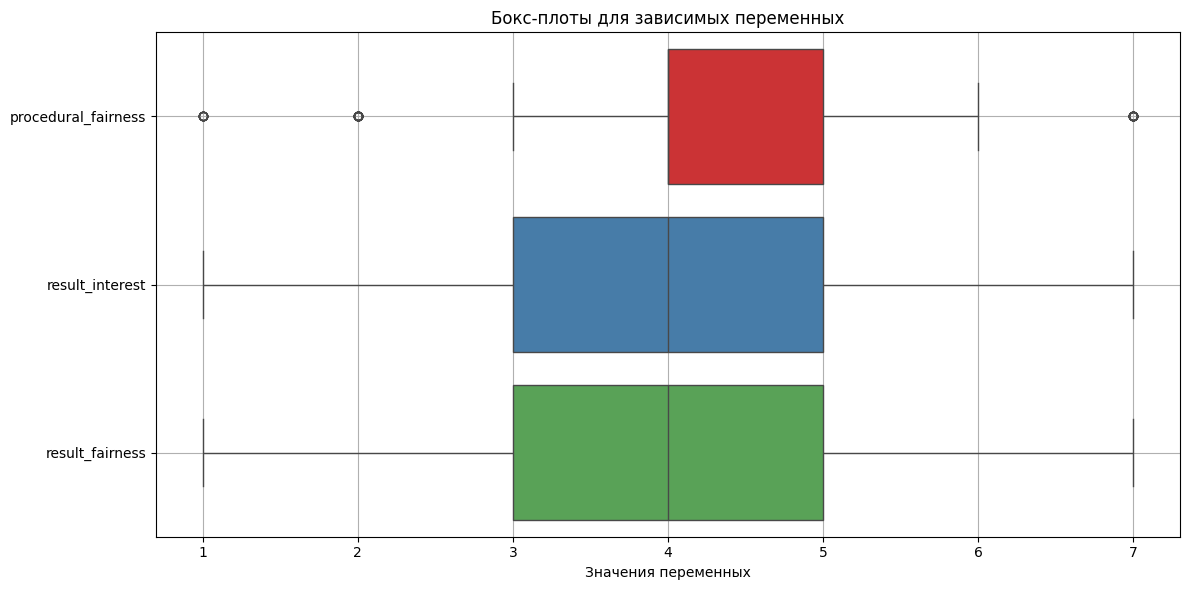

In [10]:
dependent_vars = ['procedural_fairness', 'result_interest', 'result_fairness']

plt.figure(figsize=(12, 6))  
sns.boxplot(data=data[dependent_vars], orient='h', palette='Set1')
plt.savefig("box_plot_fairness.png", dpi=400) 

plt.title('Бокс-плоты для зависимых переменных')
plt.xlabel('Значения переменных')
plt.grid(True)
plt.tight_layout()
plt.show()

Распределение отличается от нормального. Тем не менее, регрессия все еще работает, так как важна нормальность распределения остатков.

## ATE, t-tests, Манн-Уитни

ATE и t-tests для проверки гипотезы о равенстве средних между контрольными группами и группами с делиберативным типом демократических инноваций

In [11]:
from scipy.stats import ttest_ind, mannwhitneyu

In [12]:
group_treatment1 = data[data['group'].isin([2,3,4,5])]['procedural_fairness']
group_control = data[data['group'].isin([0, 1])]['procedural_fairness']
ATE = group_treatment1.mean() - group_control.mean()
u_stat, wilcoxon_p = mannwhitneyu(group_treatment1, group_control, alternative='two-sided')
print(f"(ATE): {ATE:.3f}")
print(f'W-test: {u_stat:.3f}, p_w: {wilcoxon_p:.3f}')
t_stat, p_val = ttest_ind(group_treatment1, group_control, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

(ATE): -0.163
W-test: 11310.000, p_w: 0.244
t-statistic: -1.201, p-value: 0.231


ATE и t-tests для проверки гипотезы о равенстве средних между контрольными группами и группами с агонистическим типом демократических инноваций

In [13]:
group_treatment2 = data[data['group'].isin([6, 7, 8, 9])]['procedural_fairness']
group_control = data[data['group'].isin([0, 1])]['procedural_fairness']
ATE = group_treatment2.mean() - group_control.mean()
print(f" (ATE): {ATE:.3f}")
u_stat, wilcoxon_p = mannwhitneyu(group_treatment2, group_control, alternative='two-sided')
print(f'W-test: {u_stat:.3f}, p_w: {wilcoxon_p:.3f}')
t_stat, p_val = ttest_ind(group_treatment2, group_control, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

 (ATE): -0.053
W-test: 12630.000, p_w: 0.868
t-statistic: -0.377, p-value: 0.706


ATE и t-tests для проверки гипотезы о равенстве средних между контрольными группами и группами с делиберативным типом демократических инноваций

In [14]:
from scipy.stats import ttest_ind
group_treatment1 = data[data['group'].isin([2,3,4,5])]['result_fairness']
group_control = data[data['group'].isin([0, 1])]['result_fairness']
ATE = group_treatment1.mean() - group_control.mean()
u_stat, wilcoxon_p = mannwhitneyu(group_treatment1, group_control, alternative='two-sided')
print(f" (ATE): {ATE:.3f}")
print(f'W-test: {u_stat:.3f}, p_w: {wilcoxon_p:.3f}')
t_stat, p_val = ttest_ind(group_treatment1, group_control, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

 (ATE): -0.121
W-test: 11546.500, p_w: 0.393
t-statistic: -0.781, p-value: 0.436


In [15]:
group_treatment2 = data[data['group'].isin([6, 7, 8, 9])]['result_fairness']
group_control = data[data['group'].isin([0, 1])]['result_fairness']
ATE = group_treatment2.mean() - group_control.mean()
print(f" (ATE): {ATE:.3f}")
u_stat, wilcoxon_p = mannwhitneyu(group_treatment2, group_control, alternative='two-sided')
print(f'W-test: {u_stat:.3f}, p_w: {wilcoxon_p:.3f}')
t_stat, p_val = ttest_ind(group_treatment2, group_control, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

 (ATE): 0.013
W-test: 12807.500, p_w: 0.959
t-statistic: 0.082, p-value: 0.934


In [16]:
from scipy.stats import ttest_ind
group_treatment1 = data[data['group'].isin([2,3,4,5])]['result_interest']
group_control = data[data['group'].isin([0, 1])]['result_interest']
ATE = group_treatment1.mean() - group_control.mean()
u_stat, wilcoxon_p = mannwhitneyu(group_treatment1, group_control, alternative='two-sided')
print(f" (ATE): {ATE:.3f}")
print(f'W-test: {u_stat:.3f}, p_w: {wilcoxon_p:.3f}')
t_stat, p_val = ttest_ind(group_treatment1, group_control, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

 (ATE): -0.056
W-test: 12026.000, p_w: 0.806
t-statistic: -0.355, p-value: 0.723


In [17]:
group_treatment2 = data[data['group'].isin([6, 7, 8, 9])]['result_interest']
group_control = data[data['group'].isin([0, 1])]['result_interest']
ATE = group_treatment2.mean() - group_control.mean()
print(f" (ATE): {ATE:.3f}")
u_stat, wilcoxon_p = mannwhitneyu(group_treatment2, group_control, alternative='two-sided')
print(f'W-test: {u_stat:.3f}, p_w: {wilcoxon_p:.3f}')
t_stat, p_val = ttest_ind(group_treatment2, group_control, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

 (ATE): 0.080
W-test: 13216.000, p_w: 0.583
t-statistic: 0.513, p-value: 0.608


In [18]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

results = {
    "Группа": ["Делиберативная", "Агонистическая"],
    "ATE": [-0.163, -0.053],
    "t-statistic": [-1.201, -0.377],
    "t-p-value": [0.231, 0.706],
    "W-statistic": [11310.0, 12630.0],
    "W-p-value": [0.244, 0.868]
}

df = pd.DataFrame(results)

latex_code = df.to_latex(index=False, float_format="%.3f")
print(latex_code)

\begin{tabular}{lrrrrr}
\toprule
Группа & ATE & t-statistic & t-p-value & W-statistic & W-p-value \\
\midrule
Делиберативная & -0.163 & -1.201 & 0.231 & 11310.000 & 0.244 \\
Агонистическая & -0.053 & -0.377 & 0.706 & 12630.000 & 0.868 \\
\bottomrule
\end{tabular}



In [19]:
results = {
    "Группа": ["Делиберативная", "Агонистическая"],
    "ATE": [-0.121, 0.013],
    "t-statistic": [-0.781, 0.082],
    "t-p-value": [0.436,  0.934],
    "W-statistic": [11546.500, 12807.500],
    "W-p-value": [0.393, 0.959]
}

df = pd.DataFrame(results)


latex_code = df.to_latex(index=False, float_format="%.3f")
print(latex_code)

\begin{tabular}{lrrrrr}
\toprule
Группа & ATE & t-statistic & t-p-value & W-statistic & W-p-value \\
\midrule
Делиберативная & -0.121 & -0.781 & 0.436 & 11546.500 & 0.393 \\
Агонистическая & 0.013 & 0.082 & 0.934 & 12807.500 & 0.959 \\
\bottomrule
\end{tabular}



In [20]:
results = {
    "Группа": ["Делиберативная", "Агонистическая"],
    "ATE": [-0.056, 0.080],
    "t-statistic": [-0.355, 0.513],
    "t-p-value": [0.723, 0.608],
    "W-statistic": [12026.000, 13216.000],
    "W-p-value": [0.806, 0.583]
}

df = pd.DataFrame(results)

latex_code = df.to_latex(index=False, float_format="%.3f")
print(latex_code)

\begin{tabular}{lrrrrr}
\toprule
Группа & ATE & t-statistic & t-p-value & W-statistic & W-p-value \\
\midrule
Делиберативная & -0.056 & -0.355 & 0.723 & 12026.000 & 0.806 \\
Агонистическая & 0.080 & 0.513 & 0.608 & 13216.000 & 0.583 \\
\bottomrule
\end{tabular}



#### Попарная проверка с каждой из 8 экспериментальных групп: за 0 - контрольная группа - закон не принят, 1 - закон принят
* Экспериментальные: 2 - народ принял - закон принят, 3 - народ принял - закон не принят, 4 - народ не принял - закон принят, 5 - народ не принял, закон отклонен, 6 - народ принял - закон принят, 7 - народ принял - закон не принят, 8 - народ не принял - закон принят, 9 - народ не принял - закон отклонен
* #### Зависимая переменная - процедурная справедливость

In [21]:
from scipy.stats import ttest_ind
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

In [22]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = 0 
experimental_codes = [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)
for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['procedural_fairness']
    group_control = data[data['group'] == control_code]['procedural_fairness']
    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)
    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)
    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df)

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0           1 vs 0            0.142         4.407           4.548         59   
1           2 vs 0           -0.024         4.407           4.383         59   
2           3 vs 0           -0.234         4.407           4.173         59   
3           4 vs 0           -0.024         4.407           4.383         59   
4           5 vs 0           -0.067         4.407           4.339         59   
5           6 vs 0            0.420         4.407           4.827         59   
6           7 vs 0           -0.143         4.407           4.264         59   
7           8 vs 0           -0.092         4.407           4.315         59   
8           9 vs 0           -0.099         4.407           4.308         59   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           62        0.633           0.528                 1.000   
1           47       -0.105           0.917                 1

In [23]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = 1 
experimental_codes = [0, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['procedural_fairness']
    group_control = data[data['group'] == control_code]['procedural_fairness']
    

    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)


    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0           0 vs 1           -0.142         4.548           4.407         62   
1           2 vs 1           -0.165         4.548           4.383         62   
2           3 vs 1           -0.375         4.548           4.173         62   
3           4 vs 1           -0.165         4.548           4.383         62   
4           5 vs 1           -0.209         4.548           4.339         62   
5           6 vs 1            0.279         4.548           4.827         62   
6           7 vs 1           -0.284         4.548           4.264         62   
7           8 vs 1           -0.234         4.548           4.315         62   
8           9 vs 1           -0.241         4.548           4.308         62   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           59       -0.633           0.528                 1.000   
1           47       -0.746           0.457                 1

Вывод 1: Группа 6 (agonistic treatment - приняли/приняли) значимость 0.082 => оценка процедуры как более справедливой на уровне значимости 0.1 по сравнению с контрольной группой 0, где закон не принят. Важно учесть, что различия обусловлены в том числе тем, что закон о ББД не был принят в контрольной, а в группе 6 - наоборот принят. Поэтому результат может быть смещен. Мы проверили на поправку Бонферрони, p-value не показывают значимости, тем не менее - мы видим тенденцию в более положительной оценке агонистического результата про t-тестах, тест Манна-Уитни такой результат в целом не подтверждает  
Вывод 2: Группа 3 (delib treatment), где происходит сравнение с контрольной, где закон принят, оценивается ниже по сравнению с контрольной из-за того, что мнения граждан и парламента в данном случае не совпадают (уровень значимости 0.1), люди проголосовали за то, что закон приняли, а их мнение не учли. Люди оценивают такую процедуру ниже, чем контрольную, где закон принят.При поправке Бонферрони нет стат значимости, но так как это EDA - мы можем говорить о то, что тенденция есть и проверять с помощью регрессии. W - статистика менее значима.

Вывод: Группа 3 (delib treatment - приняли/не приняли) значимость 0.072 => оценка процедура как более справедливой на уровне значимости 0.1 => оценивают как менее справедливую (вероятно, потому что к мнению людей не прислушались). То есть там, где к мнению людей не прислушались, оценка процедуры ниже.

In [24]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = [0,1]
experimental_codes = [2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['procedural_fairness']
    group_control = data[data['group'].isin(control_code)]['procedural_fairness']
    

    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)


    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0      2 vs [0, 1]           -0.096         4.479           4.383        121   
1      3 vs [0, 1]           -0.306         4.479           4.173        121   
2      4 vs [0, 1]           -0.096         4.479           4.383        121   
3      5 vs [0, 1]           -0.140         4.479           4.339        121   
4      6 vs [0, 1]            0.348         4.479           4.827        121   
5      7 vs [0, 1]           -0.215         4.479           4.264        121   
6      8 vs [0, 1]           -0.165         4.479           4.315        121   
7      9 vs [0, 1]           -0.172         4.479           4.308        121   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           47       -0.495           0.622                 1.000   
1           52       -1.678           0.096                 0.769   
2           47       -0.521           0.603                 1.000   
3  

* Вывод: при совмещенной контрольной, где закон не принят + принят мы имеем:
На уровне значимости 0.1: Менее справедливой считается экспериментальная группа 2 - с делиберативным тритментом, где к мнению народу не прислушались. Более справедливой мы можем считать группу 6 - где к мнению народа прислушались. Это говорит о том, что в целом демократические инновации оцениваются выше, это подтверждение гипотезы 1. Тем не менее, мы не подтверждаем часть а гипотезы 2 (Делиберативная модель демократии окажется: а) наиболее предпочтительной с точки зрения процедурной справедливости в целом;), потому что агонистическая модель считается более справедливой.*

С учетом поправки Бонферрони мы не можем говорить о стат значимых выводах и гипотезах, но в качестве EDA мы заметили тенденции.

* Гипотеза 1: (На оценку процедурной справедливости влияет наличие демократических инноваций при принятии политических решений, при их наличии уровень оценки процедурной справедливости выше)- тенденция может быть подтверждена, но очень слабо - на уровне значимости 0.1 (Группа 6 (agonistic treatment - приняли/приняли) значимость 0.082 и 0.096)
На оценку процедурной справедливости влияет наличие демократических инноваций при принятии политических решений, при их наличии уровень оценки процедурной справедливости выше
Группа 6: народ проголосовал за + законопроект приняли
На уровне 0.1 возможно есть слабая статистическая значимость для групп 3 и 6 (p ~ 0.096–0.097), что указывает на тенденцию к влиянию.
Группа 3: народ проголосовал за, а парламент не принял.

С учетом поправки мы не можем говорить о действительном подтверждении гипотез, поэтому, учитывая наличие трендов, мы в дальйнешем проверим это на регрессиях вместе с контролем переменных.

#### Зависимая переменная - справедливость результата

In [25]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = 0
experimental_codes = [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['result_fairness']
    group_control = data[data['group'] == control_code]['result_fairness']
    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)
    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0           1 vs 0            0.320         4.051           4.371         59   
1           2 vs 0            0.077         4.051           4.128         59   
2           3 vs 0           -0.205         4.051           3.846         59   
3           4 vs 0            0.311         4.051           4.362         59   
4           5 vs 0            0.021         4.051           4.071         59   
5           6 vs 0            0.776         4.051           4.827         59   
6           7 vs 0           -0.145         4.051           3.906         59   
7           8 vs 0            0.005         4.051           4.056         59   
8           9 vs 0            0.084         4.051           4.135         59   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           62        1.286           0.201                 1.000   
1           47        0.288           0.774                 1

* Гипотеза 3: Агонистическая модель демократии окажется менее предпочтительной по сравнению с делиберативной в связи с оценкой справедливости результата, так как основа обсуждения – дебаты, что может ассоциироваться с непрочностью решений и нестабильностью! - не подтверждена на уровне значимости 0.05 (первично на EDA), так как агонистическая модель демократии в срезе справедливости результата оказалось значимой и с положительным t, а также это подтвердилось и с W-статистикой, а также с поправками Боннеферонни.

!Для устойчивости найденного результата нам потребуется проверка с помощью линейной регрессии.

In [26]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = 1
experimental_codes = [0, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['result_fairness']
    group_control = data[data['group'] == control_code]['result_fairness']
    

    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)


    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0           0 vs 1           -0.320         4.371           4.051         62   
1           2 vs 1           -0.243         4.371           4.128         62   
2           3 vs 1           -0.525         4.371           3.846         62   
3           4 vs 1           -0.009         4.371           4.362         62   
4           5 vs 1           -0.300         4.371           4.071         62   
5           6 vs 1            0.456         4.371           4.827         62   
6           7 vs 1           -0.465         4.371           3.906         62   
7           8 vs 1           -0.315         4.371           4.056         62   
8           9 vs 1           -0.236         4.371           4.135         62   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           59       -1.286           0.201                 1.000   
1           47       -0.909           0.366                 1

Значима группа делиберативная с эффектом народ принял - парламент отклонил, отрицательно влияет на уровень справедливости результата, так как есть расхождение между мнением граждан и мнением парламента.
Положительно влияет группа 6 - агонистическая на уровне значимости 0.1, группа 7 (народ принял, депутаты отклонили) значима на уровне 0.1 - справедливость результата ниже. Тенденция на значимость при двух разных контрольных группах - подтверждается.

С поправками Бонферонни и на W-статистике результаты не значимы, что говорит о том, что нужно проверять наши результаты с помощью линейной регрессии.

In [27]:
groups =[]
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = [0,1]
experimental_codes = [0, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['result_fairness']
    group_control = data[data['group'].isin(control_code)]['result_fairness']
    

    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)


    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0      0 vs [0, 1]           -0.164         4.215           4.051        121   
1      2 vs [0, 1]           -0.087         4.215           4.128        121   
2      3 vs [0, 1]           -0.369         4.215           3.846        121   
3      4 vs [0, 1]            0.147         4.215           4.362        121   
4      5 vs [0, 1]           -0.143         4.215           4.071        121   
5      6 vs [0, 1]            0.612         4.215           4.827        121   
6      7 vs [0, 1]           -0.309         4.215           3.906        121   
7      8 vs [0, 1]           -0.159         4.215           4.056        121   
8      9 vs [0, 1]           -0.080         4.215           4.135        121   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           59       -0.763           0.447                 1.000   
1           47       -0.369           0.713                 1

#### Зависимая переменная - интерес к результату

In [28]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = 0
experimental_codes = [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['result_interest']
    group_control = data[data['group'] == control_code]['result_interest']
    
    # T-test
    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)

    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0           1 vs 0            0.569         3.898           4.468         59   
1           2 vs 0            0.378         3.898           4.277         59   
2           3 vs 0           -0.187         3.898           3.712         59   
3           4 vs 0            0.485         3.898           4.383         59   
4           5 vs 0            0.298         3.898           4.196         59   
5           6 vs 0            0.890         3.898           4.788         59   
6           7 vs 0            0.102         3.898           4.000         59   
7           8 vs 0            0.324         3.898           4.222         59   
8           9 vs 0            0.179         3.898           4.077         59   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           62        2.323           0.022                 0.197   
1           47        1.496           0.138                 1

Группа 4 (народ не принял, парламент принял) значима на уровне 0.1 и положительно влияет на субъективную оценку интереса к результату (по сравнению с тем, что закон не принят). При поправке Бонферрони - не значима.
Группа 6 устойчиво показывает повышение интереса к результату на уровне значимости 0.05

In [29]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = 1
experimental_codes = [0, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['result_interest']
    group_control = data[data['group'] == control_code]['result_interest']
    

    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)

    
    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0           0 vs 1           -0.569         4.468           3.898         62   
1           2 vs 1           -0.191         4.468           4.277         62   
2           3 vs 1           -0.756         4.468           3.712         62   
3           4 vs 1           -0.085         4.468           4.383         62   
4           5 vs 1           -0.271         4.468           4.196         62   
5           6 vs 1            0.321         4.468           4.788         62   
6           7 vs 1           -0.468         4.468           4.000         62   
7           8 vs 1           -0.246         4.468           4.222         62   
8           9 vs 1           -0.391         4.468           4.077         62   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           59       -2.323           0.022                 0.197   
1           47       -0.744           0.458                 1

Результат менее субъективно интересен в группе 3 (народ за, парламент не принял закон) по сравнению с группой 1 (закон принят), тут случай не совпадения мнений парламента и граждан, что повлияо на негативную оценку интереса к результату на уровне значимости 0.05. С поправкой Бонферрони и после проверки на статистику W - результат все еще значим.
С поправкой Бонферрони группа 7 - уже не значима, но в ней также есть тенденция - мнения людей (проголосовали за) и мнение парламента (проголосовали против) - не совпадает, что негативно влияет на субъективную оценку интереса к законопроекту.

In [30]:
groups = []
ate_values = []
t_stats = []
p_values = []
bonf_p_values = []
u_stats = []
wilcoxon_p_values = []
wilcoxon_bonf_p_values = []
control_means = []
treatment_means = []
control_sizes = []
treatment_sizes = []

control_code = [0,1]
experimental_codes = [0, 2, 3, 4, 5, 6, 7, 8, 9]
n_comparisons = len(experimental_codes)

for exp_code in experimental_codes:
    group_treatment = data[data['group'] == exp_code]['result_interest']
    group_control = data[data['group'].isin(control_code)]['result_interest']
    
    ATE = group_treatment.mean() - group_control.mean()
    t_stat, p_val = ttest_ind(group_treatment, group_control, equal_var=False)
    bonf_p = min(p_val * n_comparisons, 1.0)

    u_stat, wilcoxon_p = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
    wilcoxon_bonf_p = min(wilcoxon_p * n_comparisons, 1.0)

    groups.append(f"{exp_code} vs {control_code}")
    ate_values.append(ATE)
    t_stats.append(t_stat)
    p_values.append(p_val)
    bonf_p_values.append(bonf_p)
    u_stats.append(u_stat)
    wilcoxon_p_values.append(wilcoxon_p)
    wilcoxon_bonf_p_values.append(wilcoxon_bonf_p)
    control_means.append(group_control.mean())
    treatment_means.append(group_treatment.mean())
    control_sizes.append(group_control.count())
    treatment_sizes.append(group_treatment.count())

results_df = pd.DataFrame({
    'Group Comparison': groups,
    'ATE (Mean Diff)': ate_values,
    'Control Mean': control_means,
    'Treatment Mean': treatment_means,
    'Control N': control_sizes,
    'Treatment N': treatment_sizes,
    't-statistic': t_stats,
    't-test p-value': p_values,
    'Bonferroni t p-value': bonf_p_values,
    'U-statistic': u_stats,
    'Wilcoxon p-value': wilcoxon_p_values,
    'Bonferroni Wilcoxon p-value': wilcoxon_bonf_p_values
})

results_df = results_df.round(3)
print(results_df) 

  Group Comparison  ATE (Mean Diff)  Control Mean  Treatment Mean  Control N  \
0      0 vs [0, 1]           -0.292          4.19           3.898        121   
1      2 vs [0, 1]            0.087          4.19           4.277        121   
2      3 vs [0, 1]           -0.479          4.19           3.712        121   
3      4 vs [0, 1]            0.193          4.19           4.383        121   
4      5 vs [0, 1]            0.006          4.19           4.196        121   
5      6 vs [0, 1]            0.598          4.19           4.788        121   
6      7 vs [0, 1]           -0.190          4.19           4.000        121   
7      8 vs [0, 1]            0.032          4.19           4.222        121   
8      9 vs [0, 1]           -0.113          4.19           4.077        121   

   Treatment N  t-statistic  t-test p-value  Bonferroni t p-value  \
0           59       -1.381           0.170                 1.000   
1           47        0.385           0.701                 1

* #### Гипотеза 3 - агонистическая демократия более предпочтительна по сравнению с контрольной на уровне значимости 0.02 - гипотеза не подтверждена (о том, что делиберативная демократия cправедливее с точки зрения результата)


6 группа - демократическая инновация - агонистическая демократия влияет на более высокую оценку интереса к результату на уровне значимости 0.05 (при поправке Бонферрони и на критерии Манна Уитни p-value значим на уровне 0.1), также можем заметить что в группе 4 (делиберативная инновация - народ не принял, депутаты приняли) - оценка интереса к результату выше (при поправке Бонферрони и на критерии Манна Уитни p-value значим на уровне 0.1).
* #### Гипотеза 4: Респонденты, вовлеченные в демократические инновации, с большей вероятностью оценивают принятое решение, как соответствующее их интересам -> подтверждена (первично на EDA)

6 группа на уровне значимости 0.05 - значима. Агонистическая демократия более справедлива с точки зрения результата, чем КГ -> гипотеза 2 не подтверждена в пользу агонистической демократии

### Манн-Уитни для оценки объединенных экспериментальных групп

In [31]:
group_treatment = data[data['group'].isin([2,3,4,5])]['procedural_fairness']
group_control = data[data['group'].isin([0, 1])]['procedural_fairness']

u_stat, p_val = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_val:.3f}")

U-statistic: 11310.000, p-value: 0.244


In [32]:
group_treatment = data[data['group'].isin([6, 7, 8, 9])]['procedural_fairness']
group_control = data[data['group'].isin([0, 1])]['procedural_fairness']

u_stat, p_val = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_val:.3f}")

U-statistic: 12630.000, p-value: 0.868


In [33]:
group_treatment = data[data['group'].isin([2, 3, 4, 5])]['result_fairness']
group_control = data[data['group'].isin([0, 1])]['result_fairness']

u_stat, p_val = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_val:.3f}")

U-statistic: 11546.500, p-value: 0.393


In [34]:
group_treatment = data[data['group'].isin([6,7, 8, 9])]['result_fairness']
group_control = data[data['group'].isin([0, 1])]['result_fairness']

u_stat, p_val = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_val:.3f}")

U-statistic: 12807.500, p-value: 0.959


In [35]:
group_treatment = data[data['group'].isin([2, 3, 4, 5])]['result_interest']
group_control = data[data['group'].isin([0, 1])]['result_interest']

u_stat, p_val = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_val:.3f}")

U-statistic: 12026.000, p-value: 0.806


In [36]:
group_treatment = data[data['group'].isin([6, 7, 8, 9])]['result_interest']
group_control = data[data['group'].isin([0, 1])]['result_interest']

u_stat, p_val = mannwhitneyu(group_treatment, group_control, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_val:.3f}")

U-statistic: 13216.000, p-value: 0.583


#### * Гипотезы не в объединенных группах не подтверждаются, но учитывая межгрупповые t-тесты можем заметить тенденцию, что более справедливой и субъективно интересной респонденты считали те инновации, где совпадали мнения граждан и решение парламента. Такое предположение мы и проверим с помощью множественных линейных регрессий 

### Множественная регрессия и множественная регрессия с переменными взаимодействия (образование, положительное совпадение мнения граждан и парламента)

In [37]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

In [38]:
data

,procedural_fairness,group,econ_attitude,ideology,gender,age,educ,income_level,location,result_fairness,result_interest,parliament_decision,procedure_type,public_parliament_agreement
0,6,1,1,4,1,26,3,3,3,6,7,1,0,0
1,5,1,4,4,1,29,5,4,4,3,3,1,0,0
2,7,1,4,5,1,36,2,3,2,7,7,1,0,0
3,3,1,6,5,0,27,5,4,2,3,3,1,0,0
4,6,1,2,1,0,52,5,3,4,4,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,6,9,6,7,0,22,3,4,2,6,6,0,2,1
530,5,9,1,7,0,35,5,4,2,3,3,0,2,1
531,4,9,4,5,0,50,3,3,2,4,4,0,2,1
532,5,9,1,4,1,31,5,3,2,6,5,0,2,1


In [39]:
print(data.columns)

Index(['procedural_fairness', 'group', 'econ_attitude', 'ideology', 'gender',
       'age', 'educ', 'income_level', 'location', 'result_fairness',
       'result_interest', 'parliament_decision ', 'procedure_type',
       'public_parliament_agreement'],
      dtype='object')


                             OLS Regression Results                            
Dep. Variable:     procedural_fairness   R-squared:                       0.021
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     1.261
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):              0.256
Time:                         21:17:22   Log-Likelihood:                -839.04
No. Observations:                  534   AIC:                             1698.
Df Residuals:                      524   BIC:                             1741.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

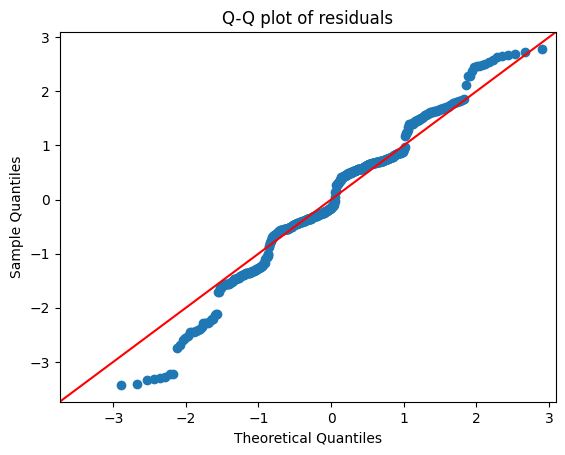

                  feature        VIF
0               Intercept  69.190964
1  C(procedure_type)[T.1]   1.683941
2  C(procedure_type)[T.2]   1.834759
3                  gender   1.038050
4                     age   1.207075
5                    educ   1.078893
6            income_level   1.048195
7                location   1.027355
8                ideology   1.065441
9           econ_attitude   1.051252


In [40]:
model1 = smf.ols('procedural_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model1.summary())

residuals = model1.resid
exog = model1.model.exog  
bp_test = het_breuschpagan(residuals, exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'procedural_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                            OLS Regression Results                            
Dep. Variable:        result_fairness   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8061
Date:                Thu, 05 Jun 2025   Prob (F-statistic):              0.611
Time:                        21:17:22   Log-Likelihood:                -897.77
No. Observations:                 534   AIC:                             1816.
Df Residuals:                     524   BIC:                             1858.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

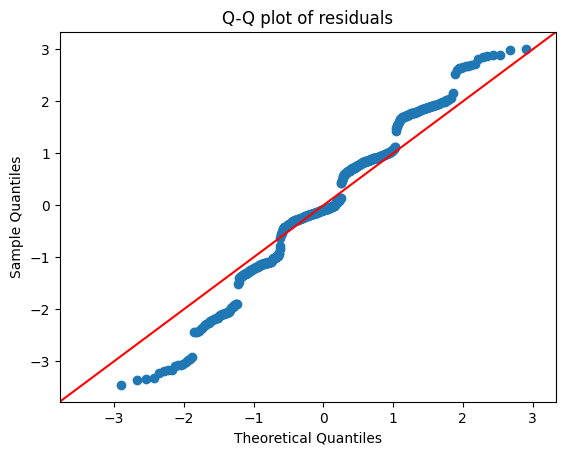

                  feature        VIF
0               Intercept  69.190964
1  C(procedure_type)[T.1]   1.683941
2  C(procedure_type)[T.2]   1.834759
3                  gender   1.038050
4                     age   1.207075
5                    educ   1.078893
6            income_level   1.048195
7                location   1.027355
8                ideology   1.065441
9           econ_attitude   1.051252


In [41]:
model2 = smf.ols('result_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model2.summary())

residuals2 = model2.resid
exog2 = model2.model.exog  
bp_test = het_breuschpagan(residuals2, exog2)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals2, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'result_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                            OLS Regression Results                            
Dep. Variable:        result_interest   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.458
Date:                Thu, 05 Jun 2025   Prob (F-statistic):              0.160
Time:                        21:17:22   Log-Likelihood:                -919.56
No. Observations:                 534   AIC:                             1859.
Df Residuals:                     524   BIC:                             1902.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

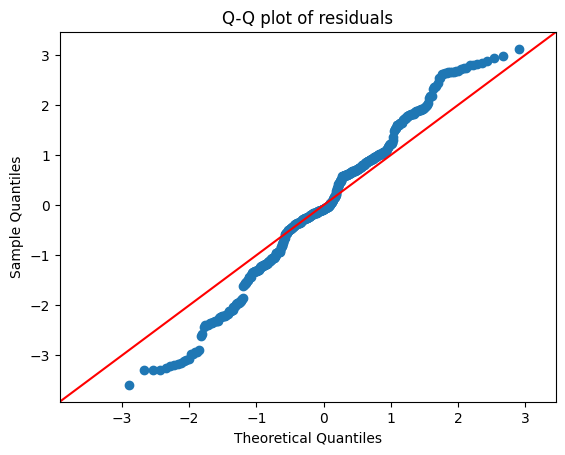

                  feature        VIF
0               Intercept  69.190964
1  C(procedure_type)[T.1]   1.683941
2  C(procedure_type)[T.2]   1.834759
3                  gender   1.038050
4                     age   1.207075
5                    educ   1.078893
6            income_level   1.048195
7                location   1.027355
8                ideology   1.065441
9           econ_attitude   1.051252


In [42]:
model3 = smf.ols('result_interest ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model3.summary())
residuals3 = model3.resid
exog3 = model3.model.exog  
bp_test = het_breuschpagan(residuals3, exog3)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals3, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'result_interest ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [43]:
from stargazer.stargazer import Stargazer

stargazer = Stargazer([model1, model2, model3])
stargazer.title("Table: Results")
stargazer.covariate_order([
    'C(procedure_type)[T.1]', 
    'C(procedure_type)[T.2]', 
    'gender', 
    'age', 
    'educ', 
    'income_level', 
    'location', 
    'ideology', 
    'econ_attitude'
])
stargazer.title("Dependent variable: p_fairness, r__fairness, r_interest")
stargazer.show_model_numbers(False)

In [44]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Dependent variable: p_fairness, r__fairness, r_interest}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\hline \\[-1.8ex]
 C(procedure_type)[T.1] & -0.159$^{}$ & -0.115$^{}$ & -0.072$^{}$ \\
& (0.136) & (0.152) & (0.158) \\
 C(procedure_type)[T.2] & -0.056$^{}$ & 0.014$^{}$ & -0.001$^{}$ \\
& (0.141) & (0.157) & (0.164) \\
 gender & -0.093$^{}$ & -0.000$^{}$ & -0.008$^{}$ \\
& (0.104) & (0.116) & (0.121) \\
 age & -0.003$^{}$ & -0.002$^{}$ & -0.011$^{}$ \\
& (0.006) & (0.006) & (0.006) \\
 educ & 0.005$^{}$ & -0.037$^{}$ & -0.072$^{}$ \\
& (0.048) & (0.054) & (0.056) \\
 income_level & -0.098$^{}$ & -0.064$^{}$ & -0.097$^{}$ \\
& (0.066) & (0.074) & (0.077) \\
 location & -0.009$^{}$ & 0.012$^{}$ & -0.100$^{**}$ \\
& (0.037) & (0.041) & (0.043) \\
 ideology & -0.033$^{}$ & -0.015$^{}$ & -0.021$^{}$ \\
& (0.031) & (0.035) & (0.036) \\
 econ_attitude & 0.069$^{**}$ & 0.072$^{*}$ & 0.026$^{}$ \\
& (0.033) & (0.037) &

                             OLS Regression Results                            
Dep. Variable:     procedural_fairness   R-squared:                       0.039
Model:                             OLS   Adj. R-squared:                  0.009
Method:                  Least Squares   F-statistic:                     1.301
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):              0.191
Time:                         21:17:23   Log-Likelihood:                -834.22
No. Observations:                  534   AIC:                             1702.
Df Residuals:                      517   BIC:                             1775.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.7404      0.452 

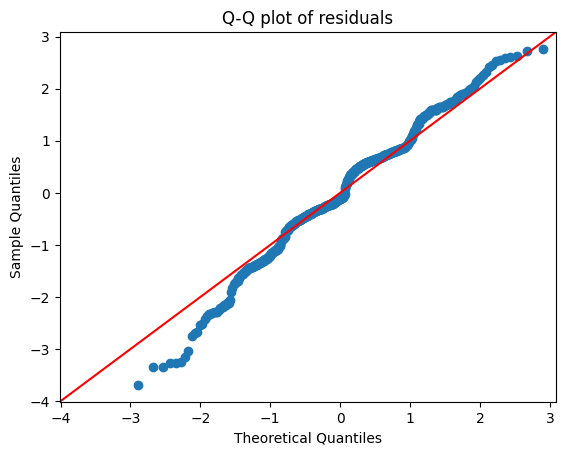

          feature        VIF
0       Intercept  79.140903
1   C(group)[T.1]   1.860592
2   C(group)[T.2]   1.666674
3   C(group)[T.3]   1.734357
4   C(group)[T.4]   1.685919
5   C(group)[T.5]   1.782933
6   C(group)[T.6]   1.874856
7   C(group)[T.7]   1.809841
8   C(group)[T.8]   1.827755
9   C(group)[T.9]   1.847760
10         gender   1.075819
11            age   1.241106
12           educ   1.101117
13   income_level   1.050615
14       location   1.034648
15       ideology   1.071554
16  econ_attitude   1.062675


In [45]:
model4= smf.ols('procedural_fairness ~ C(group) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model4.summary())

residuals4 = model4.resid
exog4 = model4.model.exog  
bp_test = het_breuschpagan(residuals4, exog4)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals4, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'procedural_fairness ~ C(group) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [46]:
from stargazer.stargazer import Stargazer
stargazer = Stargazer([model4])
stargazer.title("Table: Results")
stargazer.covariate_order([
    'C(group)[T.1]', 
    'C(group)[T.2]',
    'C(group)[T.3]', 
     'C(group)[T.4]',
     'C(group)[T.5]',
     'C(group)[T.6]', 
     'C(group)[T.7]', 
     'C(group)[T.8]', 
     'C(group)[T.9]', 
    'gender', 
    'age', 
    'educ', 
    'income_level', 
    'location', 
    'ideology', 
    'econ_attitude'
])
stargazer.title("Dependent variable: p_fairness, r__fairness, r_interest")
stargazer.show_model_numbers(False)

In [47]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Dependent variable: p_fairness, r__fairness, r_interest}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: procedural_fairness}} \
\cr \cline{2-2}
\hline \\[-1.8ex]
 C(group)[T.1] & 0.134$^{}$ \\
& (0.216) \\
 C(group)[T.2] & -0.048$^{}$ \\
& (0.231) \\
 C(group)[T.3] & -0.232$^{}$ \\
& (0.225) \\
 C(group)[T.4] & -0.037$^{}$ \\
& (0.233) \\
 C(group)[T.5] & -0.027$^{}$ \\
& (0.221) \\
 C(group)[T.6] & 0.425$^{*}$ \\
& (0.234) \\
 C(group)[T.7] & -0.117$^{}$ \\
& (0.228) \\
 C(group)[T.8] & -0.082$^{}$ \\
& (0.228) \\
 C(group)[T.9] & -0.130$^{}$ \\
& (0.233) \\
 gender & -0.123$^{}$ \\
& (0.106) \\
 age & -0.002$^{}$ \\
& (0.006) \\
 educ & 0.016$^{}$ \\
& (0.049) \\
 income_level & -0.099$^{}$ \\
& (0.066) \\
 location & -0.007$^{}$ \\
& (0.037) \\
 ideology & -0.035$^{}$ \\
& (0.031) \\
 econ_attitude & 0.062$^{*}$ \\
& (0.033) \\
\hline \\[-1.8ex]
 Observations & 534

### На уровне значимости 0.1 гипотеза о том, что демократические инновации положительно влияют на справедливость процедуры подтверждена.

Проблематики гетероскдастичности не возникает

                             OLS Regression Results                            
Dep. Variable:     procedural_fairness   R-squared:                       0.022
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     1.083
Date:                 Fri, 06 Jun 2025   Prob (F-statistic):              0.372
Time:                         23:45:36   Log-Likelihood:                -838.74
No. Observations:                  534   AIC:                             1701.
Df Residuals:                      522   BIC:                             1753.
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercep

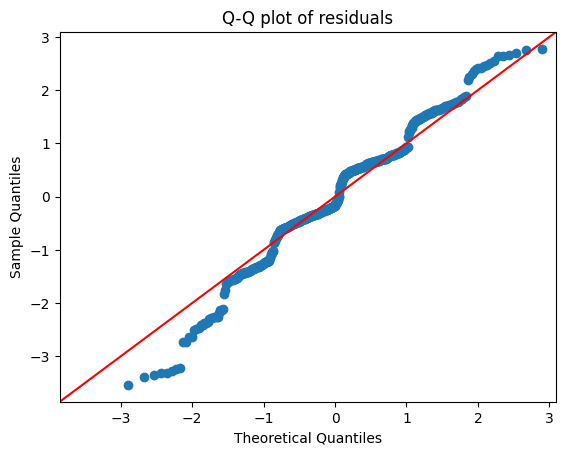

                        feature         VIF
0                     Intercept  107.224539
1        C(procedure_type)[T.1]   22.948664
2        C(procedure_type)[T.2]   22.690058
3                          educ    4.280552
4   C(procedure_type)[T.1]:educ   24.733020
5   C(procedure_type)[T.2]:educ   23.525231
6                        gender    1.050041
7                           age    1.208164
8                  income_level    1.051454
9                      location    1.030351
10                     ideology    1.069031
11                econ_attitude    1.051431


In [83]:
model5 = smf.ols('procedural_fairness ~ C(procedure_type)*educ + gender + age + income_level + location + ideology + econ_attitude', data=data).fit()
print(model5.summary())
residuals5 = model5.resid
exog5 = model5.model.exog  
bp_test = het_breuschpagan(residuals5, exog5)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals5, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'procedural_fairness ~ C(procedure_type)*educ + gender + age + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [49]:
from stargazer.stargazer import Stargazer
stargazer = Stargazer([model5])
stargazer.title("Table: Results")
stargazer.covariate_order([
    'C(procedure_type)[T.1]', 
    'C(procedure_type)[T.2]',
    'C(procedure_type)[T.1]:educ', 
     'C(procedure_type)[T.2]:educ',
    'gender', 
    'age', 
    'educ', 
    'income_level', 
    'location', 
    'ideology', 
    'econ_attitude'
])
stargazer.title("Dependent variable: p_fairness, r__fairness, r_interest")
stargazer.show_model_numbers(False)

In [50]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Dependent variable: p_fairness, r__fairness, r_interest}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: procedural_fairness}} \
\cr \cline{2-2}
\hline \\[-1.8ex]
 C(procedure_type)[T.1] & -0.449$^{}$ \\
& (0.503) \\
 C(procedure_type)[T.2] & -0.415$^{}$ \\
& (0.496) \\
 C(procedure_type)[T.1]:educ & 0.074$^{}$ \\
& (0.122) \\
 C(procedure_type)[T.2]:educ & 0.092$^{}$ \\
& (0.122) \\
 gender & -0.101$^{}$ \\
& (0.105) \\
 age & -0.003$^{}$ \\
& (0.006) \\
 educ & -0.058$^{}$ \\
& (0.096) \\
 income_level & -0.096$^{}$ \\
& (0.066) \\
 location & -0.008$^{}$ \\
& (0.037) \\
 ideology & -0.033$^{}$ \\
& (0.031) \\
 econ_attitude & 0.069$^{**}$ \\
& (0.033) \\
\hline \\[-1.8ex]
 Observations & 534 \\
 $R^2$ & 0.022 \\
 Adjusted $R^2$ & 0.002 \\
 Residual Std. Error & 1.177 (df=522) \\
 F Statistic & 1.083$^{}$ (df=11; 522) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \mul

                             OLS Regression Results                            
Dep. Variable:     procedural_fairness   R-squared:                       0.051
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     1.099
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):              0.339
Time:                         21:17:23   Log-Likelihood:                -830.71
No. Observations:                  534   AIC:                             1713.
Df Residuals:                      508   BIC:                             1825.
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.0

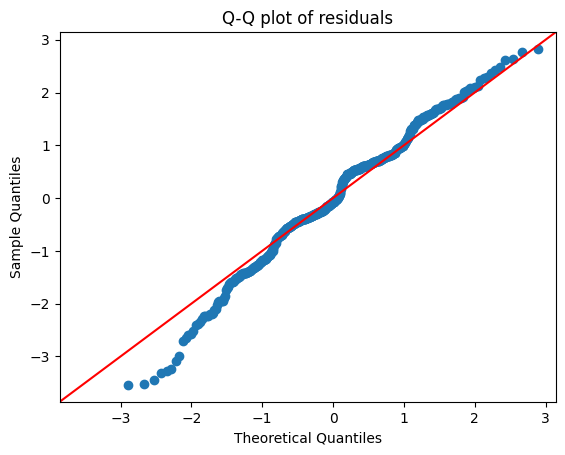

               feature         VIF
0            Intercept  209.776660
1        C(group)[T.1]   25.297324
2        C(group)[T.2]   28.584189
3        C(group)[T.3]   26.864995
4        C(group)[T.4]   23.016562
5        C(group)[T.5]   27.811771
6        C(group)[T.6]   23.393371
7        C(group)[T.7]   32.288697
8        C(group)[T.8]   27.667590
9        C(group)[T.9]   25.077440
10                educ    9.907984
11  C(group)[T.1]:educ   23.420067
12  C(group)[T.2]:educ   29.305744
13  C(group)[T.3]:educ   27.126930
14  C(group)[T.4]:educ   22.141659
15  C(group)[T.5]:educ   27.585986
16  C(group)[T.6]:educ   21.614343
17  C(group)[T.7]:educ   32.601324
18  C(group)[T.8]:educ   27.514408
19  C(group)[T.9]:educ   22.697655
20              gender    1.120644
21                 age    1.278584
22        income_level    1.082335
23            location    1.047188
24            ideology    1.088416
25       econ_attitude    1.072959


In [51]:
model6 = smf.ols('procedural_fairness ~ C(group)*educ + gender + age + income_level + location + ideology + econ_attitude', data=data).fit()
print(model6.summary())
residuals6 = model6.resid
exog6 = model6.model.exog  
bp_test = het_breuschpagan(residuals6, exog6)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals6, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'procedural_fairness ~ C(group)*educ + gender + age + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [52]:
from scipy.stats import shapiro
residual = model6.resid
stat, p = shapiro(residual)
print(f"Shapiro–Wilk test: stat={stat:.3f}, p-value={p:.3f}")

if p > 0.05:
    print("Распределение остатков не отличается от нормального (не отвергаем H0)")
else:
    print("Остатки не распределены нормально (отвергаем H0)")

Shapiro–Wilk test: stat=0.987, p-value=0.000
Остатки не распределены нормально (отвергаем H0)


In [53]:
from stargazer.stargazer import Stargazer
stargazer = Stargazer([model6])
stargazer.title("Table: Results")
stargazer.covariate_order([
    'C(group)[T.1]', 
    'C(group)[T.2]',
    'C(group)[T.3]', 
     'C(group)[T.4]',
     'C(group)[T.5]',
     'C(group)[T.6]', 
     'C(group)[T.7]', 
     'C(group)[T.8]', 
     'C(group)[T.9]', 
    'C(group)[T.1]:educ', 
    'C(group)[T.2]:educ',
    'C(group)[T.3]:educ', 
     'C(group)[T.4]:educ',
     'C(group)[T.5]:educ',
     'C(group)[T.6]:educ', 
     'C(group)[T.7]:educ', 
     'C(group)[T.8]:educ', 
     'C(group)[T.9]:educ', 
    'gender', 
    'age', 
    'educ', 
    'income_level', 
    'location', 
    'ideology', 
    'econ_attitude'
])
stargazer.title("Dependent variable: p_fairness, r__fairness, r_interest")
stargazer.show_model_numbers(False)

In [54]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Dependent variable: p_fairness, r__fairness, r_interest}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: procedural_fairness}} \
\cr \cline{2-2}
\hline \\[-1.8ex]
 C(group)[T.1] & 0.048$^{}$ \\
& (0.799) \\
 C(group)[T.2] & 0.622$^{}$ \\
& (0.960) \\
 C(group)[T.3] & -0.912$^{}$ \\
& (0.889) \\
 C(group)[T.4] & -0.421$^{}$ \\
& (0.861) \\
 C(group)[T.5] & -0.735$^{}$ \\
& (0.876) \\
 C(group)[T.6] & -0.650$^{}$ \\
& (0.830) \\
 C(group)[T.7] & -1.045$^{}$ \\
& (0.967) \\
 C(group)[T.8] & -0.195$^{}$ \\
& (0.887) \\
 C(group)[T.9] & 0.012$^{}$ \\
& (0.859) \\
 C(group)[T.1]:educ & 0.016$^{}$ \\
& (0.194) \\
 C(group)[T.2]:educ & -0.156$^{}$ \\
& (0.224) \\
 C(group)[T.3]:educ & 0.166$^{}$ \\
& (0.209) \\
 C(group)[T.4]:educ & 0.094$^{}$ \\
& (0.208) \\
 C(group)[T.5]:educ & 0.176$^{}$ \\
& (0.210) \\
 C(group)[T.6]:educ & 0.281$^{}$ \\
& (0.204) \\
 C(group)[T.7]:educ &

### H2 - Делиберативная модель демократии окажется: а) наиболее предпочтительной с точки зрения процедурной справедливости в целом; б) наиболее предпочтительна с точки зрения процедурной справедливости среди людей с высшим образованием, так как модель опирается на рациональную аргументацию .
### H2 - не подтвеждена

### Гипотеза 2 - не подтверждена

                            OLS Regression Results                            
Dep. Variable:        result_fairness   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8061
Date:                Thu, 05 Jun 2025   Prob (F-statistic):              0.611
Time:                        21:17:23   Log-Likelihood:                -897.77
No. Observations:                 534   AIC:                             1816.
Df Residuals:                     524   BIC:                             1858.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

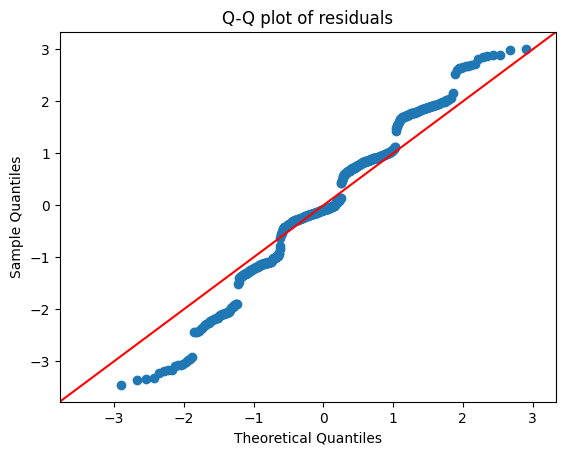

                  feature        VIF
0               Intercept  69.190964
1  C(procedure_type)[T.1]   1.683941
2  C(procedure_type)[T.2]   1.834759
3                  gender   1.038050
4                     age   1.207075
5                    educ   1.078893
6            income_level   1.048195
7                location   1.027355
8                ideology   1.065441
9           econ_attitude   1.051252


In [55]:
model7 = smf.ols('result_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model7.summary())

residuals7 = model7.resid
exog7 = model7.model.exog  
bp_test = het_breuschpagan(residuals7, exog7)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals7, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'result_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [56]:
from scipy.stats import shapiro
residual = model7.resid
stat, p = shapiro(residual)
print(f"Shapiro–Wilk test: stat={stat:.3f}, p-value={p:.3f}")

if p > 0.05:
    print("Распределение остатков не отличается от нормального (не отвергаем H0)")
else:
    print("Остатки не распределены нормально (отвергаем H0)")

Shapiro–Wilk test: stat=0.981, p-value=0.000
Остатки не распределены нормально (отвергаем H0)


                            OLS Regression Results                            
Dep. Variable:        result_fairness   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.700
Date:                Thu, 05 Jun 2025   Prob (F-statistic):             0.0431
Time:                        21:17:23   Log-Likelihood:                -887.75
No. Observations:                 534   AIC:                             1810.
Df Residuals:                     517   BIC:                             1882.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.1010      0.499      8.216

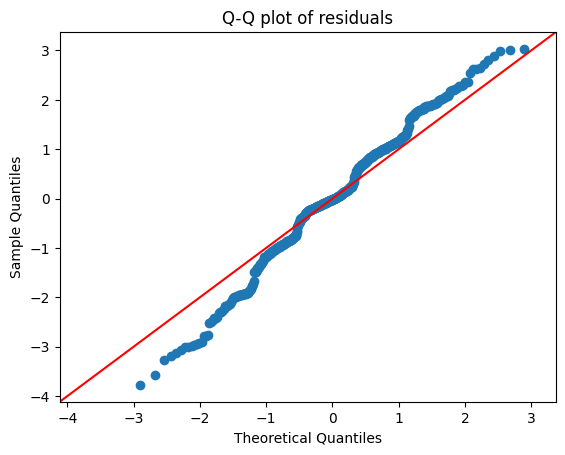

          feature        VIF
0       Intercept  79.140903
1   C(group)[T.1]   1.860592
2   C(group)[T.2]   1.666674
3   C(group)[T.3]   1.734357
4   C(group)[T.4]   1.685919
5   C(group)[T.5]   1.782933
6   C(group)[T.6]   1.874856
7   C(group)[T.7]   1.809841
8   C(group)[T.8]   1.827755
9   C(group)[T.9]   1.847760
10         gender   1.075819
11            age   1.241106
12           educ   1.101117
13   income_level   1.050615
14       location   1.034648
15       ideology   1.071554
16  econ_attitude   1.062675


In [57]:
model8 = smf.ols('result_fairness ~ C(group) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model8.summary())
residuals8 = model8.resid
exog8 = model8.model.exog  
bp_test = het_breuschpagan(residuals8, exog8)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals8, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'result_fairness ~ C(group) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [58]:
from stargazer.stargazer import Stargazer

stargazer = Stargazer([model8])
stargazer.title("Table: Results")
stargazer.covariate_order([
    'C(group)[T.1]', 
    'C(group)[T.2]',
    'C(group)[T.3]', 
     'C(group)[T.4]',
     'C(group)[T.5]',
     'C(group)[T.6]', 
     'C(group)[T.7]', 
     'C(group)[T.8]', 
     'C(group)[T.9]', 
    'gender', 
    'age', 
    'educ', 
    'income_level', 
    'location', 
    'ideology', 
    'econ_attitude'
])
stargazer.title("Dependent variable: p_fairness, r__fairness, r_interest")
stargazer.show_model_numbers(False)

In [59]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Dependent variable: p_fairness, r__fairness, r_interest}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: result_fairness}} \
\cr \cline{2-2}
\hline \\[-1.8ex]
 C(group)[T.1] & 0.316$^{}$ \\
& (0.239) \\
 C(group)[T.2] & 0.068$^{}$ \\
& (0.256) \\
 C(group)[T.3] & -0.185$^{}$ \\
& (0.249) \\
 C(group)[T.4] & 0.303$^{}$ \\
& (0.257) \\
 C(group)[T.5] & 0.046$^{}$ \\
& (0.245) \\
 C(group)[T.6] & 0.791$^{***}$ \\
& (0.259) \\
 C(group)[T.7] & -0.111$^{}$ \\
& (0.252) \\
 C(group)[T.8] & 0.036$^{}$ \\
& (0.252) \\
 C(group)[T.9] & 0.088$^{}$ \\
& (0.257) \\
 gender & -0.026$^{}$ \\
& (0.117) \\
 age & 0.001$^{}$ \\
& (0.006) \\
 educ & -0.013$^{}$ \\
& (0.054) \\
 income_level & -0.066$^{}$ \\
& (0.073) \\
 location & 0.015$^{}$ \\
& (0.041) \\
 ideology & -0.016$^{}$ \\
& (0.034) \\
 econ_attitude & 0.058$^{}$ \\
& (0.037) \\
\hline \\[-1.8ex]
 Observations & 534 \\
 $R^2

### Гипотеза 3 - по сравнению одной контрольной и двух экспериментальных - не подтверждена

                            OLS Regression Results                            
Dep. Variable:        result_interest   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.458
Date:                Thu, 05 Jun 2025   Prob (F-statistic):              0.160
Time:                        21:17:23   Log-Likelihood:                -919.56
No. Observations:                 534   AIC:                             1859.
Df Residuals:                     524   BIC:                             1902.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

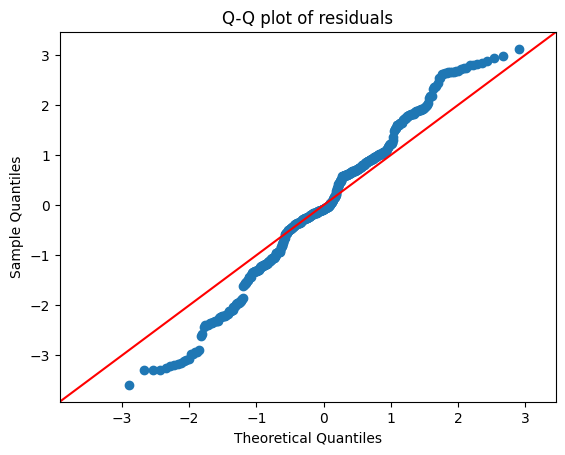

                  feature        VIF
0               Intercept  69.190964
1  C(procedure_type)[T.1]   1.683941
2  C(procedure_type)[T.2]   1.834759
3                  gender   1.038050
4                     age   1.207075
5                    educ   1.078893
6            income_level   1.048195
7                location   1.027355
8                ideology   1.065441
9           econ_attitude   1.051252


In [60]:
model9 = smf.ols('result_interest ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model9.summary())
residuals9 = model9.resid
exog9 = model9.model.exog  
bp_test = het_breuschpagan(residuals9, exog9)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals9, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'result_interest ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                            OLS Regression Results                            
Dep. Variable:        result_interest   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.140
Date:                Thu, 05 Jun 2025   Prob (F-statistic):            0.00616
Time:                        21:17:23   Log-Likelihood:                -909.05
No. Observations:                 534   AIC:                             1852.
Df Residuals:                     517   BIC:                             1925.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.1350      0.519      9.886

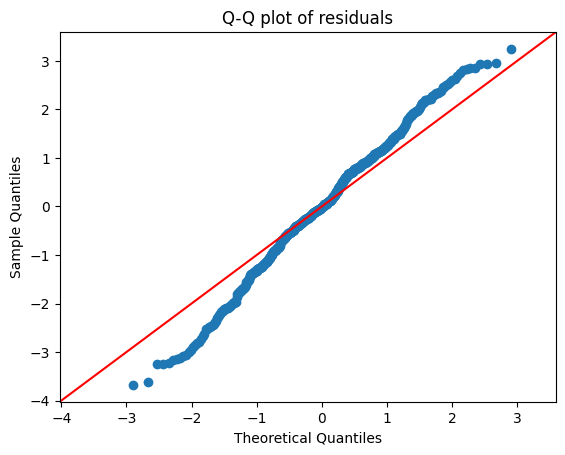

          feature        VIF
0       Intercept  79.140903
1   C(group)[T.1]   1.860592
2   C(group)[T.2]   1.666674
3   C(group)[T.3]   1.734357
4   C(group)[T.4]   1.685919
5   C(group)[T.5]   1.782933
6   C(group)[T.6]   1.874856
7   C(group)[T.7]   1.809841
8   C(group)[T.8]   1.827755
9   C(group)[T.9]   1.847760
10         gender   1.075819
11            age   1.241106
12           educ   1.101117
13   income_level   1.050615
14       location   1.034648
15       ideology   1.071554
16  econ_attitude   1.062675


In [61]:
model10 = smf.ols('result_interest ~ C(group) + gender + age + educ + income_level + location + ideology + econ_attitude', data=data).fit()
print(model10.summary())
residuals10 = model10.resid
exog10 = model10.model.exog  
bp_test = het_breuschpagan(residuals10, exog10)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals10, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'result_interest ~ C(group) + gender + age + educ + income_level + location + ideology + econ_attitude', 
    data=data, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [62]:
from stargazer.stargazer import Stargazer


stargazer = Stargazer([model10])
stargazer.title("Table: Results")
stargazer.covariate_order([
    'C(group)[T.1]', 
    'C(group)[T.2]',
    'C(group)[T.3]', 
     'C(group)[T.4]',
     'C(group)[T.5]',
     'C(group)[T.6]', 
     'C(group)[T.7]', 
     'C(group)[T.8]', 
     'C(group)[T.9]', 
    'gender', 
    'age', 
    'educ', 
    'income_level', 
    'location', 
    'ideology', 
    'econ_attitude'
])
stargazer.title("Dependent variable: p_fairness, r__fairness, r_interest")
stargazer.show_model_numbers(False)

In [63]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Dependent variable: p_fairness, r__fairness, r_interest}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: result_interest}} \
\cr \cline{2-2}
\hline \\[-1.8ex]
 C(group)[T.1] & 0.490$^{**}$ \\
& (0.249) \\
 C(group)[T.2] & 0.321$^{}$ \\
& (0.266) \\
 C(group)[T.3] & -0.249$^{}$ \\
& (0.259) \\
 C(group)[T.4] & 0.424$^{}$ \\
& (0.268) \\
 C(group)[T.5] & 0.274$^{}$ \\
& (0.254) \\
 C(group)[T.6] & 0.763$^{***}$ \\
& (0.270) \\
 C(group)[T.7] & 0.041$^{}$ \\
& (0.263) \\
 C(group)[T.8] & 0.227$^{}$ \\
& (0.262) \\
 C(group)[T.9] & 0.054$^{}$ \\
& (0.268) \\
 gender & -0.056$^{}$ \\
& (0.122) \\
 age & -0.008$^{}$ \\
& (0.006) \\
 educ & -0.051$^{}$ \\
& (0.056) \\
 income_level & -0.098$^{}$ \\
& (0.076) \\
 location & -0.095$^{**}$ \\
& (0.042) \\
 ideology & -0.024$^{}$ \\
& (0.036) \\
 econ_attitude & 0.011$^{}$ \\
& (0.038) \\
\hline \\[-1.8ex]
 Observations & 534 \\


#### Гипотеза 4 - подтверждена, наличие демократической инновации положительно влияет на субъективную оценку интереса к результату

#### Попробуем рассмотреть иные взаимодействия, чтобы подтвердить гипотезы:

In [64]:

data_no_control = data[~data['group'].isin([0, 1])].copy() 

data_no_control.rename(columns=lambda x: x.strip(), inplace=True)


data_no_control["posititve_pp_agreement"] = 0
data_no_control.loc[
    (data_no_control["parliament_decision"] == 1) & 
    (data_no_control["public_parliament_agreement"] == 1),
    "posititve_pp_agreement"
] = 1

                             OLS Regression Results                            
Dep. Variable:     procedural_fairness   R-squared:                       0.049
Model:                             OLS   Adj. R-squared:                  0.023
Method:                  Least Squares   F-statistic:                     1.884
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):             0.0398
Time:                         21:17:23   Log-Likelihood:                -637.97
No. Observations:                  413   AIC:                             1300.
Df Residuals:                      401   BIC:                             1348.
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

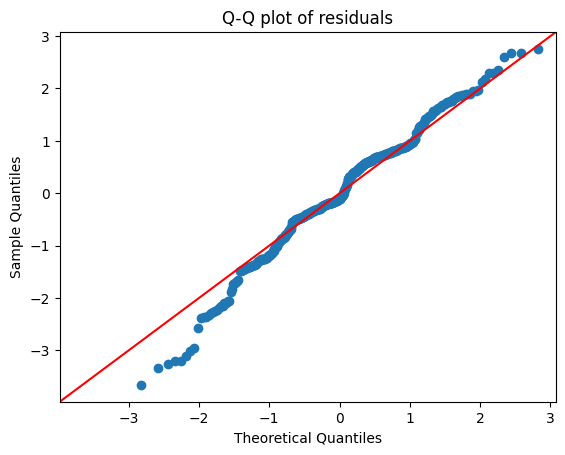

                                          feature        VIF
0                                       Intercept  72.443001
1                          C(procedure_type)[T.2]   6.302402
2                                          gender   1.056303
3                                             age   1.204624
4                                            educ   1.091489
5                                    income_level   1.048945
6                                        location   1.041778
7                                        ideology   1.070629
8                                   econ_attitude   2.412420
9            econ_attitude:C(procedure_type)[T.2]   7.185424
10                         posititve_pp_agreement   2.124276
11  posititve_pp_agreement:C(procedure_type)[T.2]   2.489232


In [65]:
model11 = smf.ols('procedural_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type) + econ_attitude*C(procedure_type)', data=data_no_control).fit()
print(model11.summary())
residuals11 = model11.resid
exog11 = model11.model.exog  
bp_test = het_breuschpagan(residuals11, exog11)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals11, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'procedural_fairness ~ C(procedure_type) + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type) + econ_attitude*C(procedure_type)', 
    data=data_no_control, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                             OLS Regression Results                            
Dep. Variable:     procedural_fairness   R-squared:                       0.049
Model:                             OLS   Adj. R-squared:                  0.025
Method:                  Least Squares   F-statistic:                     2.063
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):             0.0264
Time:                         21:17:24   Log-Likelihood:                -638.04
No. Observations:                  413   AIC:                             1298.
Df Residuals:                      402   BIC:                             1342.
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

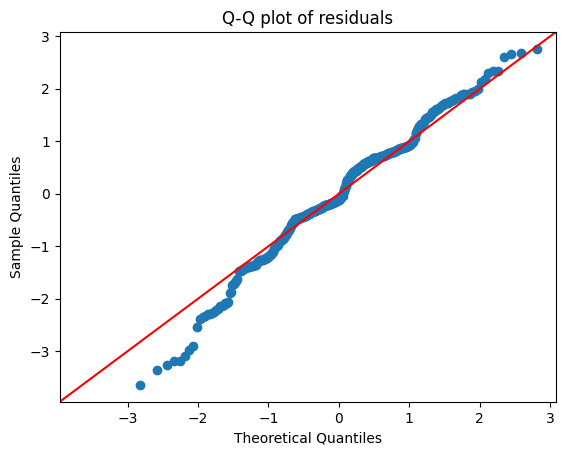

                                          feature        VIF
0                                       Intercept  68.156124
1                          C(procedure_type)[T.2]   1.400211
2                                          gender   1.056164
3                                             age   1.197044
4                                            educ   1.090519
5                                    income_level   1.043186
6                                        location   1.038985
7                                        ideology   1.069026
8                                   econ_attitude   1.070271
9                          posititve_pp_agreement   2.114938
10  posititve_pp_agreement:C(procedure_type)[T.2]   2.478775


In [66]:
model12 = smf.ols('procedural_fairness ~ + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type)', data=data_no_control).fit()
print(model12.summary())
residuals12 = model12.resid
exog12 = model12.model.exog  
bp_test = het_breuschpagan(residuals12, exog12)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals12, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'procedural_fairness ~ + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type)', 
    data=data_no_control, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

Вывод: с помощью взаимодействия согласованности парламента и граждан + сравнения экспериментальных групп друг с другом на уровне значимости ниже 0.1 и на грани с 0.05 -> в группе с процедурой типа 2 (агонистическая группа), при наличии согласия с решением парламента и общественным согласием, наблюдается рост справедливости на ~0.5 балла по сравнению с делиберативной демократией.

Мы можем говорить о том, что респонденты видят значимые различия в оценке процедурной справедливости между двумя моделями.

                            OLS Regression Results                            
Dep. Variable:        result_fairness   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.656
Date:                Thu, 05 Jun 2025   Prob (F-statistic):            0.00377
Time:                        21:17:24   Log-Likelihood:                -678.23
No. Observations:                 413   AIC:                             1378.
Df Residuals:                     402   BIC:                             1423.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

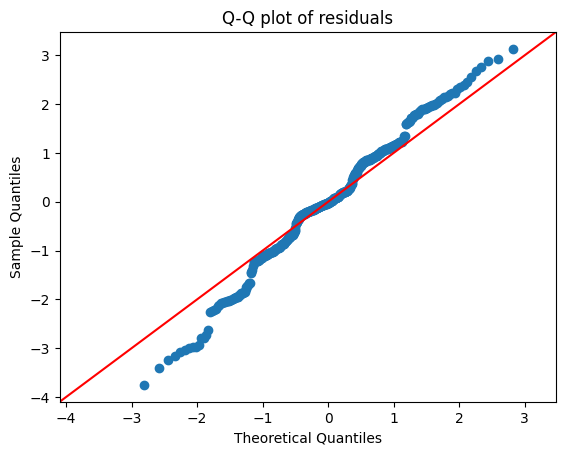

                                          feature        VIF
0                                       Intercept  68.156124
1                          C(procedure_type)[T.2]   1.400211
2                                          gender   1.056164
3                                             age   1.197044
4                                            educ   1.090519
5                                    income_level   1.043186
6                                        location   1.038985
7                                        ideology   1.069026
8                                   econ_attitude   1.070271
9                          posititve_pp_agreement   2.114938
10  posititve_pp_agreement:C(procedure_type)[T.2]   2.478775


In [67]:
model13 = smf.ols('result_fairness ~ + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type)', data=data_no_control).fit()
print(model13.summary())
residuals13 = model13.resid
exog13 = model13.model.exog  
bp_test = het_breuschpagan(residuals13, exog13)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals13, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'result_fairness ~ + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type)', 
    data=data_no_control, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

Гипотеза о снижении предпочтительности агонистической модели (процедуры 2) не подтверждается на уровне 0.05. Напротив, результаты показывают, что при наличии восприятия общественного согласия с решением, процедура 2 повышает оценку справедливости результата. Это может свидетельствовать о том, что даже в условиях поляризации и дебатов, характерных для агонистической демократии, результат воспринимается как справедливый — возможно, за счёт открытости конфликта, большей вовлечённости или представления различных точек зрения.

In [68]:
from stargazer.stargazer import Stargazer
stargazer = Stargazer([model13])
stargazer.title("Table: Results")
stargazer.covariate_order([
    'C(procedure_type)[T.2]', 
    'posititve_pp_agreement',
    'posititve_pp_agreement:C(procedure_type)[T.2]', 
    'gender', 
    'age', 
    'educ', 
    'income_level', 
    'location', 
    'ideology', 
    'econ_attitude'
])
stargazer.title("Dependent variable: p_fairness, r__fairness, r_interest")
stargazer.show_model_numbers(False)

In [69]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Dependent variable: p_fairness, r__fairness, r_interest}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: result_fairness}} \
\cr \cline{2-2}
\hline \\[-1.8ex]
 C(procedure_type)[T.2] & -0.024$^{}$ \\
& (0.148) \\
 posititve_pp_agreement & 0.005$^{}$ \\
& (0.212) \\
 posititve_pp_agreement:C(procedure_type)[T.2] & 0.780$^{***}$ \\
& (0.296) \\
 gender & -0.031$^{}$ \\
& (0.129) \\
 age & 0.004$^{}$ \\
& (0.007) \\
 educ & -0.030$^{}$ \\
& (0.060) \\
 income_level & -0.119$^{}$ \\
& (0.079) \\
 location & 0.019$^{}$ \\
& (0.046) \\
 ideology & -0.019$^{}$ \\
& (0.038) \\
 econ_attitude & 0.091$^{**}$ \\
& (0.041) \\
\hline \\[-1.8ex]
 Observations & 413 \\
 $R^2$ & 0.062 \\
 Adjusted $R^2$ & 0.039 \\
 Residual Std. Error & 1.267 (df=402) \\
 F Statistic & 2.656$^{***}$ (df=10; 402) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$

                             OLS Regression Results                            
Dep. Variable:     procedural_fairness   R-squared:                       0.049
Model:                             OLS   Adj. R-squared:                  0.025
Method:                  Least Squares   F-statistic:                     2.063
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):             0.0264
Time:                         21:17:24   Log-Likelihood:                -638.04
No. Observations:                  413   AIC:                             1298.
Df Residuals:                      402   BIC:                             1342.
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

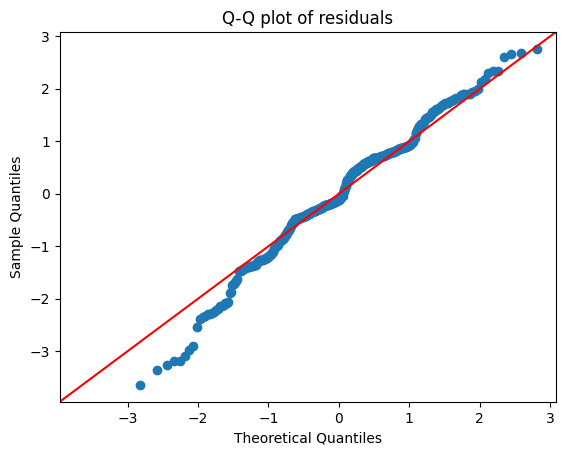

                                          feature        VIF
0                                       Intercept  68.156124
1                          C(procedure_type)[T.2]   1.400211
2                                          gender   1.056164
3                                             age   1.197044
4                                            educ   1.090519
5                                    income_level   1.043186
6                                        location   1.038985
7                                        ideology   1.069026
8                                   econ_attitude   1.070271
9                          posititve_pp_agreement   2.114938
10  posititve_pp_agreement:C(procedure_type)[T.2]   2.478775


In [70]:
model14 = smf.ols('procedural_fairness ~ + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type)', data=data_no_control).fit()
print(model14.summary())
residuals14 = model14.resid
exog14 = model14.model.exog  
bp_test = het_breuschpagan(residuals14, exog14)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(labels, bp_test):
    print(f"\n{name}: \n{value:.3f}")

sm.qqplot(residuals14, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

y, X = dmatrices(
    'procedural_fairness ~ + gender + age + educ + income_level + location + ideology + econ_attitude + posititve_pp_agreement*C(procedure_type)', 
    data=data_no_control, 
    return_type='dataframe'
)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

### Ординальная логистическая регрессия

In [71]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel
import patsy

In [72]:
data

,procedural_fairness,group,econ_attitude,ideology,gender,age,educ,income_level,location,result_fairness,result_interest,parliament_decision,procedure_type,public_parliament_agreement
0,6,1,1,4,1,26,3,3,3,6,7,1,0,0
1,5,1,4,4,1,29,5,4,4,3,3,1,0,0
2,7,1,4,5,1,36,2,3,2,7,7,1,0,0
3,3,1,6,5,0,27,5,4,2,3,3,1,0,0
4,6,1,2,1,0,52,5,3,4,4,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,6,9,6,7,0,22,3,4,2,6,6,0,2,1
530,5,9,1,7,0,35,5,4,2,3,3,0,2,1
531,4,9,4,5,0,50,3,3,2,4,4,0,2,1
532,5,9,1,4,1,31,5,3,2,6,5,0,2,1


In [73]:
X = data[[ 'procedure_type' , 'econ_attitude' , 'ideology' , 'gender', 'age', 'income_level', 'location']]   
y = data[ 'procedural_fairness' ] 

In [74]:
cross_tab = pd.crosstab(
    index=[X['procedure_type'], X['econ_attitude'], X['ideology'], X['gender'], X['age'], X['income_level']],
    columns=X['location']
)
print(cross_tab)

location                                                       1  2  3  4  5  \
procedure_type econ_attitude ideology gender age income_level                  
0              1             1        0      33  4             0  1  0  0  0   
                                      1      33  3             0  1  0  0  0   
                                             36  2             0  1  0  0  0   
                                             40  3             0  0  0  1  0   
                             3        1      56  2             0  0  0  1  0   
...                                                           .. .. .. .. ..   
2              7             7        0      28  2             0  1  0  0  0   
                                             33  4             0  0  0  0  1   
                                             52  3             0  0  0  1  0   
                                      1      31  4             1  0  0  0  0   
                                        

In [75]:
import patsy
from statsmodels.miscmodels.ordinal_model import OrderedModel

formula = 'C(group) + ideology + gender + age + income_level + location+econ_attitude'


y, X = patsy.dmatrices('procedural_fairness ~ ' + formula, data, return_type='dataframe')

X = X.loc[:, ~X.columns.str.contains('Intercept')]  


model = OrderedModel(endog=y, exog=X, distr='logit')  
result = model.fit(method='bfgs', disp=False)
print(result.summary())

                              OrderedModel Results                             
Dep. Variable:     procedural_fairness   Log-Likelihood:                -827.84
Model:                    OrderedModel   AIC:                             1698.
Method:             Maximum Likelihood   BIC:                             1788.
Date:                 Thu, 05 Jun 2025                                         
Time:                         21:17:24                                         
No. Observations:                  534                                         
Df Residuals:                      513                                         
Df Model:                           15                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
C(group)[T.1]     0.1951      0.337      0.580      0.562      -0.465       0.855
C(group)[T.2]    -0.0920      0.35

In [76]:
params = result.params
bse = result.bse
pvalues = result.pvalues

df = pd.DataFrame({
    'coef': params,
    'std_err': bse,
    'p_value': pvalues
})


def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

df['signif'] = df['p_value'].apply(stars)


df['coef_se'] = df.apply(lambda row: f"{row['coef']:.3f}{row['signif']} ({row['std_err']:.3f})", axis=1)


print(df[['coef_se']].to_latex(header=True))

\begin{tabular}{ll}
\toprule
 & coef_se \\
\midrule
C(group)[T.1] & 0.195 (0.337) \\
C(group)[T.2] & -0.092 (0.353) \\
C(group)[T.3] & -0.348 (0.344) \\
C(group)[T.4] & -0.101 (0.352) \\
C(group)[T.5] & 0.002 (0.343) \\
C(group)[T.6] & 0.668* (0.367) \\
C(group)[T.7] & -0.077 (0.356) \\
C(group)[T.8] & -0.042 (0.343) \\
C(group)[T.9] & -0.166 (0.359) \\
ideology & -0.045 (0.047) \\
gender & -0.181 (0.163) \\
age & 0.002 (0.009) \\
income_level & -0.160 (0.100) \\
location & 0.004 (0.057) \\
econ_attitude & 0.082 (0.051) \\
1.0/2.0 & -4.636*** (0.732) \\
2.0/3.0 & 0.338 (0.221) \\
3.0/4.0 & 0.323*** (0.117) \\
4.0/5.0 & 0.425*** (0.068) \\
5.0/6.0 & 0.504*** (0.069) \\
6.0/7.0 & 0.549*** (0.130) \\
\bottomrule
\end{tabular}



### 6 группа продолжает влиять на уровне значимости 0.1

In [77]:
formula = 'C(procedure_type) + ideology + gender + age + income_level + location+econ_attitude'


y, X = patsy.dmatrices('procedural_fairness ~ ' + formula, data, return_type='dataframe')

X = X.loc[:, ~X.columns.str.contains('Intercept')]  


model = OrderedModel(endog=y, exog=X, distr='logit')  
result = model.fit(method='bfgs', disp=False)
print(result.summary())

                              OrderedModel Results                             
Dep. Variable:     procedural_fairness   Log-Likelihood:                -831.86
Model:                    OrderedModel   AIC:                             1692.
Method:             Maximum Likelihood   BIC:                             1752.
Date:                 Thu, 05 Jun 2025                                         
Time:                         21:17:24                                         
No. Observations:                  534                                         
Df Residuals:                      520                                         
Df Model:                            8                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
C(procedure_type)[T.1]    -0.2376      0.209     -1.136      0.256      -0.648       0.172
C(proce

In [78]:
formula = 'C(group) + ideology + gender + age + income_level + location+ econ_attitude'


y, X = patsy.dmatrices('result_fairness ~ ' + formula, data, return_type='dataframe')

X = X.loc[:, ~X.columns.str.contains('Intercept')]  


model = OrderedModel(endog=y, exog=X, distr='logit')  
result = model.fit(method='bfgs', disp=False)
print(result.summary())

                             OrderedModel Results                             
Dep. Variable:        result_fairness   Log-Likelihood:                -878.50
Model:                   OrderedModel   AIC:                             1799.
Method:            Maximum Likelihood   BIC:                             1889.
Date:                Thu, 05 Jun 2025                                         
Time:                        21:17:25                                         
No. Observations:                 534                                         
Df Residuals:                     513                                         
Df Model:                          15                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
C(group)[T.1]     0.4990      0.336      1.483      0.138      -0.161       1.159
C(group)[T.2]     0.0462      0.357      0.

In [79]:
import pandas as pd


params = result.params
bse = result.bse
pvalues = result.pvalues

df = pd.DataFrame({
    'coef': params,
    'std_err': bse,
    'p_value': pvalues
})


def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

df['signif'] = df['p_value'].apply(stars)


df['coef_se'] = df.apply(lambda row: f"{row['coef']:.3f}{row['signif']} ({row['std_err']:.3f})", axis=1)

print(df[['coef_se']].to_latex(header=True))

\begin{tabular}{ll}
\toprule
 & coef_se \\
\midrule
C(group)[T.1] & 0.499 (0.336) \\
C(group)[T.2] & 0.046 (0.357) \\
C(group)[T.3] & -0.207 (0.346) \\
C(group)[T.4] & 0.405 (0.353) \\
C(group)[T.5] & 0.090 (0.341) \\
C(group)[T.6] & 1.144*** (0.362) \\
C(group)[T.7] & -0.122 (0.352) \\
C(group)[T.8] & 0.086 (0.338) \\
C(group)[T.9] & 0.189 (0.355) \\
ideology & -0.019 (0.047) \\
gender & -0.055 (0.162) \\
age & 0.005 (0.009) \\
income_level & -0.112 (0.100) \\
location & 0.044 (0.056) \\
econ_attitude & 0.065 (0.050) \\
1.0/2.0 & -3.253*** (0.693) \\
2.0/3.0 & 0.323** (0.160) \\
3.0/4.0 & 0.115 (0.104) \\
4.0/5.0 & 0.376*** (0.067) \\
5.0/6.0 & 0.318*** (0.080) \\
6.0/7.0 & 0.571*** (0.132) \\
\bottomrule
\end{tabular}



In [80]:
formula = 'C(group) + ideology + gender + age + income_level + location + econ_attitude'


y, X = patsy.dmatrices('result_interest ~ ' + formula, data, return_type='dataframe')

X = X.loc[:, ~X.columns.str.contains('Intercept')]  


model = OrderedModel(endog=y, exog=X, distr='logit')  
result = model.fit(method='bfgs', disp=False)
print(result.summary())

                             OrderedModel Results                             
Dep. Variable:        result_interest   Log-Likelihood:                -897.65
Model:                   OrderedModel   AIC:                             1837.
Method:            Maximum Likelihood   BIC:                             1927.
Date:                Thu, 05 Jun 2025                                         
Time:                        21:17:25                                         
No. Observations:                 534                                         
Df Residuals:                     513                                         
Df Model:                          15                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
C(group)[T.1]     0.7547      0.328      2.300      0.021       0.112       1.398
C(group)[T.2]     0.4286      0.344      1.

In [81]:
params = result.params
bse = result.bse
pvalues = result.pvalues

df = pd.DataFrame({
    'coef': params,
    'std_err': bse,
    'p_value': pvalues
})


def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

df['signif'] = df['p_value'].apply(stars)


df['coef_se'] = df.apply(lambda row: f"{row['coef']:.3f}{row['signif']} ({row['std_err']:.3f})", axis=1)


print(df[['coef_se']].to_latex(header=True))

\begin{tabular}{ll}
\toprule
 & coef_se \\
\midrule
C(group)[T.1] & 0.755** (0.328) \\
C(group)[T.2] & 0.429 (0.344) \\
C(group)[T.3] & -0.240 (0.341) \\
C(group)[T.4] & 0.616* (0.353) \\
C(group)[T.5] & 0.473 (0.335) \\
C(group)[T.6] & 1.117*** (0.360) \\
C(group)[T.7] & 0.024 (0.342) \\
C(group)[T.8] & 0.359 (0.341) \\
C(group)[T.9] & 0.234 (0.349) \\
ideology & -0.042 (0.047) \\
gender & -0.099 (0.160) \\
age & -0.007 (0.009) \\
income_level & -0.135 (0.098) \\
location & -0.116** (0.056) \\
econ_attitude & 0.001 (0.050) \\
1.0/2.0 & -4.313*** (0.687) \\
2.0/3.0 & 0.278* (0.156) \\
3.0/4.0 & 0.114 (0.102) \\
4.0/5.0 & 0.277*** (0.071) \\
5.0/6.0 & 0.378*** (0.077) \\
6.0/7.0 & 0.212 (0.136) \\
\bottomrule
\end{tabular}



In [82]:
formula = 'C(group)+ ideology + gender + age + income_level + location + econ_attitude'

y = data['procedural_fairness']

_, X = patsy.dmatrices('procedural_fairness ~ ' + formula, data, return_type='dataframe')
X = X.loc[:, ~X.columns.str.contains('Intercept')]  

X = X.loc[:, ~X.columns.str.contains('Intercept')]


model = OrderedModel(endog=y, exog=X, distr='logit')
result = model.fit(method='bfgs', disp=False)
print(result.summary())

                              OrderedModel Results                             
Dep. Variable:     procedural_fairness   Log-Likelihood:                -827.84
Model:                    OrderedModel   AIC:                             1698.
Method:             Maximum Likelihood   BIC:                             1788.
Date:                 Thu, 05 Jun 2025                                         
Time:                         21:17:26                                         
No. Observations:                  534                                         
Df Residuals:                      513                                         
Df Model:                           15                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
C(group)[T.1]     0.1951      0.337      0.580      0.562      -0.465       0.855
C(group)[T.2]    -0.0920      0.35